## Ukesoppgaver IN2070: Kompresjon og Koding II

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from numpy import fft
from urllib.request import urlretrieve

# Setter opp noen bedre standardargumenter for plotting med bilder
plt.rcParams['figure.figsize'] = [10.24, 7.68]
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Last ned testbilde vi skal bruke
url = '/studier/emner/matnat/ifi/IN2070/h23/undervisningsmateriale/bilder/lena.png'
if not os.path.isfile('lena.png'):
    urllib.request.urlretrieve(url, 'lena.png')
    
# Laster inn bilde som array med PIL og normaliserer til flyttall
image = np.array(Image.open('lena.png')) / 255

## Oppgave 1:

I denne oppgaven skal vi kode DCT-II transformen; først med en naiv matrisemultiplikasjon, så med en fast Fourier transform (`fft`) variant.

### 1a: Enkel DCT

Skriv en funksjon som regner ut DCT-II matrisen. Formelen er gitt ved

$$
\begin{align}
    \tilde x_k = \sum_{n=0}^{N-1} x_n \cos\big(k\pi (n + 1/2) / N\big),
\end{align}
$$
hvor $(x_n)_{n=0}^{N-1}$ er et 1D signal (tenk rad eller kolonne i bildet). 
Skriv også en funksjon som anvender seperabilitet for bilder for å regne ut DCT transformen gitt matrisen.
**Merk**: DCT utregningen er i standardform, og ikke ortonormal

**Tips:**
- Vi vil ha indekser for $k=0,...,N-1$ kolonner og $n=0,...,N-1$ rader i bildet. Her kan `np.meshgrid` benyttes med hell.
- Gitt arrayene `k, n` så er det enkelt å vektorisere utregningene i Numpy med `np.cos`.
- For separabilitet har vi $\tilde X = \mathcal{C} X \mathcal{C}^{\intercal}$ der $X$ er orginalbildet med dimensjon $N \times N$.
- Hva skjer hvis bildet har forskjellige dimensjoner for høyde og bredde? Tenk litt på dette.

### 1b: Invers DCT

Invers til DCT-II fra 1a (gjerne kalt DCT-III eller iDCT) er gitt ved

$$
\begin{align}
    x_k = \frac{2}{N}\Big(\frac{1}{2}x_0 + \sum_{n=1}^{N-1} \tilde x_n \cos\big(n\pi (k + 1/2) / N\big)\Big),
\end{align}
$$

Lag en funksjon som regner ut iDCT matrisen. Bekreft implementasjonen ved å skrive en funksjon som foretar iDCT og inverter deretter transformen fra 1a.

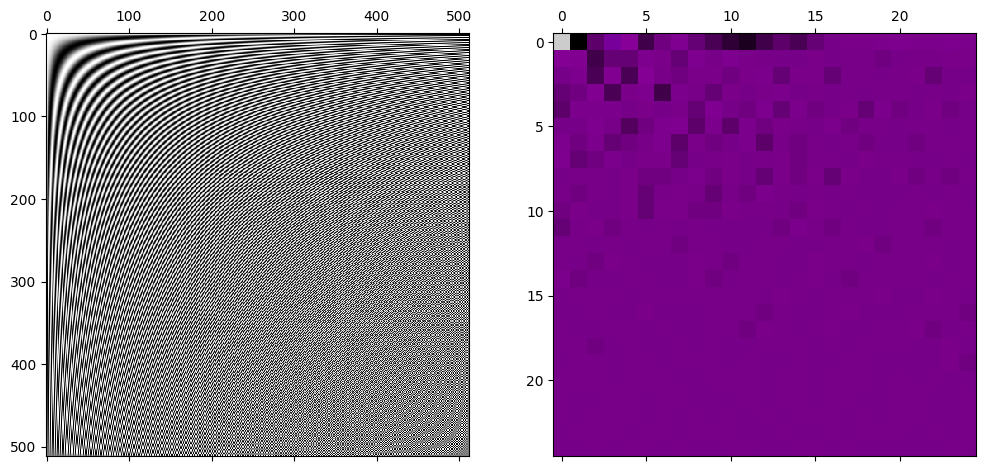

In [3]:
# Fasit 1a:
def get_dct_matrix(N):
    k, n = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    C = np.cos(k*np.pi*(n + 0.5)/N)
    return C

def dct_naive_1d(x):
    N = x.shape[-1]
    C = get_dct_matrix(N)
    return x @ C.T


def dct_naive_2d(x):
    return dct_naive_1d(dct_naive_1d(x).T).T

fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].matshow(get_dct_matrix(512))
ax[1].matshow(dct_naive_2d(image)[:25,:25], cmap='nipy_spectral') # Plotter bare rundt origo.

In [4]:
# Fasit 1b:
def get_idct_matrix(N):
    k, n = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    C = np.cos(n*np.pi*(k + 0.5)/N)
    C[:,0] = 1/2
    return 2*C / N

def idct_naive_1d(x):
    N = x.shape[-1]
    C = get_idct_matrix(N)
    return x @ C.T

def idct_naive_2d(x):
    return idct_naive_1d(idct_naive_1d(x).T).T

plt.matshow(idct_naive_2d(dct_naive_2d(image))) # Sjekker inversmatrisen

## Oppgave 2:


### 2a: WHT Matrise
Skriv en funksjon som regner ut Walsh-Hademard transformen. Bruk Hademard form av matrisen, gitt ved rekursjonen
$$
W^{(2n)} = \begin{bmatrix}
W^{(n)} & W^{(n)}\\
W^{(n)} & -W^{(n)}\\
\end{bmatrix}
$$

og bruk nullutvidelse for å utvide bildet til nærmeste potensverdi av 2.


### 2b: WHT vs. DCT

Regn ut WHT og DCT for bildet, og estimer glissenhet (sparsity) ved å ta det såkalte *Euclid-in-a-Taxicab* forholdet gitt ved

$$
\frac{\lVert x \rVert_1}{\lVert x \rVert_2} = \frac{\sum_{m=0}^{N-1} \lvert x_m \rvert}{\sqrt{\sum_{n=0}^{N-1} x_n^2}}.
$$

Jo lavere forhold (teoretisk minimum 1), jo mer glissen er transformasjonen.

In [5]:
# Fasit 2a:
def get_wht_matrix(n):
    W = np.ones((1,1))
    for _ in range(n):
        W = np.concatenate([
            np.concatenate([W, W],-1), 
            np.concatenate([W, -W],-1)
        ], 0)
    return W

def wht_naive_1d(x):
    N = x.shape[-1]
    P = int(np.ceil(np.log2(N)))
    xp = np.pad(x, ((0,0),(0,2**P-N)))
    W = get_wht_matrix(P)
    return xp @ W

def wht_naive_2d(x):
    return wht_naive_1d(wht_naive_1d(x).T).T

# Fasit 2b: DCT er bedre
np.abs(dct_naive_2d(image)).sum() / (dct_naive_2d(image)**2).sum()**.5, \
np.abs(wht_naive_2d(image)).sum() / (wht_naive_2d(image)**2).sum()**.5

(19.27976012047343, 45.61816619425509)

## Oppgave 3: LZW transform

### 3a: LZW Enkoder

Skriv en LZW Enkoder ved å benytte følgende steg:

1. **Initialisering**: Start med en ordliste (dictionary) som inneholder alle tegn i ASCII-tegnsettet, hver med sin unike kode. 
2. **Lesing**: Les inn tegn fra dataene som skal komprimeres sekvensielt.
3. **Søk i ordlisten**: For hver nye tegnsekvens, sjekk om sekvensen finnes i ordlisten.
    - Hvis den finnes, fortsett å legge til tegn til sekvensen og gjenta søket.
    - Hvis den ikke finnes, utfør følgende trinn:
4. **Lagre til ordlisten**: Legg til den nye tegnsekvensen i ordlisten med en ny unik kode.
5. **Skriv ut kode**: Skriv ut koden som tilsvarer den lengste sekvensen som finnes i ordlisten.
6. **Fortsett prosessen**: Start den nye sekvensen med det tegnet som ikke ble funnet i ordlisten og gjenta prosessen.
7. **Slutten av data**: Når det ikke er flere tegn å lese, skriv ut koden for den siste sekvensen.
8. **Output**: Komprimerte data vil være en sekvens av koder som representerer de lengre strengene i originaldataene.


**Tips**: ASCII kodesettet kan hentes ut ved `chr(i) for i in range(256)`. Det kan være lurt å teste med en liten streng underveis.

### 3b: LZW Dekoder

Skriv så en LZW dekoder, ved følgende steg:

1. **Initialisering**: Opprett en ordliste (dictionary) identisk med den som ble brukt i kompressoren.
2. **Les første kode**: Les den første koden fra de komprimerte dataene og oversett den til det tilsvarende tegnet eller tegnsekvensen fra ordlisten. Skriv ut denne sekvensen til output.
3. **Forrige sekvens**: Lagre den dekodede tegnsekvensen som den forrige sekvensen.
4. **Prosesser påfølgende koder**: For hver påfølgende kode:   
    - **Finn i ordlisten**: Oversett koden til en sekvens ved å se den opp i ordlisten.
        - Hvis koden ikke finnes i ordlisten, er det en spesiell situasjon. Sekvensen må være den forrige sekvensen pluss dens første tegn. Generer denne sekvensen.
        - Hvis koden finnes, er det direkte oversettelsen av koden til en sekvens.
    - **Skriv ut sekvens**: Skriv ut den dekodede sekvensen til output.
    - **Oppdater ordlisten**: Legg til en ny sekvens i ordlisten som er lik den forrige sekvensen pluss det første tegnet i den nåværende dekodede sekvensen.
    - **Oppdater forrige sekvens**: Sett den nåværende dekodede sekvensen som den forrige sekvensen for neste iterasjon.
5. **Fortsett til enden**: Fortsett prosessen til alle kodene er lest og dekodet.
6. **Output**: Det dekodede outputtet skal nå være en eksakt kopi av de originale dataene før de ble komprimert.


### 3c: Enkod teksten

Den vakre teksten `greatlyric` gir frysninger til alle som våger lese den. 
Enkod teksten, sjekk at den dekodes korrekt, og regn ut kompresjonsraten gitt ved 

$$
\frac{\mathrm{original\,\,lengde}}{\mathrm{enkodet\,\,lengde}}
$$

Er kompresjonsraten som forventet?

In [6]:
def lzw_encode(uncompressed):

    dict_size = 256 # ASCII
    dictionary = {chr(i): chr(i) for i in range(dict_size)}
    w = ''
    result = []
    
    for c in uncompressed:
        
        wc = w + c
        
        if wc in dictionary:
            w = wc

        else:
            result.append(dictionary[w])
            dictionary[wc] = dict_size
            dict_size += 1
            w = c

    if w:
        result.append(dictionary[w])
    return result



def lzw_decode(compressed):
    dict_size = 256 # ASCII
    dictionary = {chr(i): chr(i) for i in range(dict_size)}
    w = result = compressed.pop(0)
    
    for k in compressed:
        
        if k in dictionary:
            entry = dictionary[k]
        
        elif k == dict_size:
            entry = w + w[0]
        
        else:
            raise ValueError('Bad compressed k: %s' % k)
        
        result += entry
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
        w = entry
        
    return result

In [7]:
greatlyric = '''
Nu reser jag till Söderns land
Till varm och solig strand
Jag surfar över vågorna
Som tar mig in till land
Där flickorna, de dansar
Hula-hula natten lång
I takt med vindens melodi
Sjunger vi en sång
I vårt eget Blue Hawaii
I vårt eget Blue Hawaii
Blue Hawaii, vårt eget Blue Hawaii
Hand i hand på en solig strand
Nu är jag här i Söderns land
I mitt eget Blue Hawaii
Hon binder en fin blomsterkrans
Och hänger runt min hals
Där under sköna palmerna
Jag bjuder upp till dans
Vi vandrar tätt intill varann
I kvällens solnedgång
Och ukelelen spelar upp
Havets egen sång
I vårt eget Blue Hawaii
I vårt eget Blue Hawaii
Blue Hawaii, vårt eget Blue Hawaii
Hand i hand på en solig strand
Nu är jag här i Söderns land
I mitt eget Blue Hawaii
I vårt eget Blue Hawaii
I vårt eget Blue Hawaii
Blue Hawaii, vårt eget Blue Hawaii
Hand i hand på en solig strand
Nu är jag här i Söderns land
I mitt eget Blue Hawaii
'''

encoded_lyric = lzw_encode(greatlyric)
decoded_lyric = lzw_decode(encoded_lyric)

In [8]:
if len(decoded_lyric) == len(greatlyric) and all([d == g for d,g in zip(decoded_lyric, greatlyric)]):
    print('Grattis!')

Grattis!


In [9]:
len(greatlyric)/len(encoded_lyric)

2.0156599552572705